In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  6 14:45:06 2018
@author: wmy
"""

'\nCreated on Thu Sep  6 14:45:06 2018\n@author: wmy\n'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

In [10]:
from opt_utils import load_params_and_grads, initialize_parameters, \
forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, \
plot_decision_boundary, load_dataset
from testCases import *

In [11]:
class DeepNeuralNetwork():
    
    def __init__(self, name, layer_list):
        self.name = name
        self.Parameters_Init(layer_list)
        # it will be used when plot the costs picture
        self.iteration_unit = 1000
        print("You created a deep neural network named '" + self.name + "'")
        print('The layer list is ' + str(self.layer_list))
        pass
    
    def Parameters_Init(self, layer_list):
        self.layer_list = layer_list[:]
        np.random.seed(3)
        self.parameters = {}
        # number of layers in the network
        self.L = len(layer_list) - 1
        for l in range(1, self.L + 1):
            self.parameters['W' + str(l)] = np.random.randn(layer_list[l], \
                       layer_list[l-1]) * np.sqrt(2 / layer_list[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_list[l], 1))
            assert(self.parameters['W' + str(l)].shape == (layer_list[l], \
                                   layer_list[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_list[l], 1))
        return self.parameters
    
    def Sigmoid(self, x):
        s = 1 / (1 + np.exp(-x))
        return s

    def ReLU(self, x):
        s = np.maximum(0, x)
        return s
    
    def Forward_Propagation(self, X):
        # copy the dataset X (or A0)
        self.dataset = {} 
        self.dataset['X'] = X[:]
        # the number of datasets
        self.m = X.shape[1]
        # the caches for hidden and output layers
        self.caches = []
        assert(self.L == len(self.parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            # cache : (Zl, Al, Wl, bl)
            cache = (Z, A_now, W, b)
            self.caches.append(cache)
        WL = self.parameters['W' + str(self.L)]
        bL = self.parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        self.AL = self.Sigmoid(ZL)
        cache = (ZL, self.AL, WL, bL)
        self.caches.append(cache)
        # check the shape
        assert(self.AL.shape == (1, X.shape[1]))
        return self.AL, self.caches
    
    def Compute_Cost(self, Y):
        assert(self.m == Y.shape[1])
        # - (y * log(a) + (1-y) * log(1-a))
        logprobs = np.multiply(-np.log(self.AL),Y) + \
        np.multiply(-np.log(1 - self.AL), 1 - Y)
        # the average of the loss function
        cost = 1.0/self.m * np.nansum(logprobs)
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        self.cost = cost
        return self.cost
    
    def Backward_Propagation(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            dZ = np.multiply(dA, np.int64(A_current > 0))
            dW = 1.0/m * np.dot(dZ, A_before.T)
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Update_Parameters(self, learning_rate):
        assert(self.L == len(self.parameters) // 2)
        L = self.L
        for l in range(L):
            # W = W - a * dW
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - \
            learning_rate * self.grads["dW" + str(l + 1)]
            # b = b - a * db
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - \
            learning_rate * self.grads["db" + str(l + 1)]    
        return self.parameters
    
    def Train(self, X, Y, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations+1):
            self.Forward_Propagation(X)
            cost = self.Compute_Cost(Y)
            self.Backward_Propagation(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def Query(self, X, Y):
        m = X.shape[1]
        p = np.zeros((1,m), dtype = np.int)
        probs, caches = self.Forward_Propagation(X)
        for i in range(0, probs.shape[1]):
            if probs[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        #print("Accuracy: " + str(100*np.sum((p == Y)/m)) + '%')
        print("Accuracy: " + str(100 * np.mean((p[0,:] == Y[0,:]))) + '%')
        return p
    
    def Predict(self, X):
        m = X.shape[1]
        p = np.zeros((1,m), dtype = np.int)
        probs, caches = self.Forward_Propagation(X)
        for i in range(0, probs.shape[1]):
            if probs[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        return p   
    
    def PlotCosts(self):
        plt.plot(np.squeeze(self.costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per ' + str(self.iteration_unit) + ')')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
    
    def Dropout_Init(self, keep_prob_list):
        self.keep_prob_list = keep_prob_list
        pass
    
    def Forward_Propagation_Dropout(self, X):
        # choose the random seed
        np.random.seed(1)
        # copy the dataset X (or A0)
        self.dataset = {} 
        self.dataset['X'] = X[:]
        self.m = X.shape[1]
        # the caches for hidden and output layers
        self.caches = []
        self.D = {}
        assert(self.L == len(self.parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            # dropout
            self.D['D' + str(l)] = np.random.rand(A_now.shape[0], \
                   A_now.shape[1]) 
            self.D['D' + str(l)] = (self.D['D' + str(l)] < \
                  self.keep_prob_list[l - 1])
            A_now = A_now * self.D['D' + str(l)]
            A_now = A_now / self.keep_prob_list[l - 1]
            # cache : (Zl, Al, Wl, bl)
            cache = (Z, A_now, W, b)
            self.caches.append(cache)
        WL = self.parameters['W' + str(self.L)]
        bL = self.parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        self.AL = self.Sigmoid(ZL)
        cache = (ZL, self.AL, WL, bL)
        self.caches.append(cache)
        # check the shape
        assert(self.AL.shape == (1, X.shape[1]))
        return self.AL, self.caches
    
    def Backward_Propagation_Dropout(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            # dropout
            dA = dA * self.D['D' + str(l + 1)]
            dA = dA / self.keep_prob_list[l]
            # dropout finished
            dZ = np.multiply(dA, np.int64(A_current > 0))
            dW = 1.0/m * np.dot(dZ, A_before.T)
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Train_Dropout(self, X, Y, keep_prob_list, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.Dropout_Init(keep_prob_list)
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations+1):
            self.Forward_Propagation_Dropout(X)
            cost = self.Compute_Cost(Y)
            self.Backward_Propagation_Dropout(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def L2_Regularization_Init(self, lambda_list):
        self.lambda_list = lambda_list[:]
        pass
    
    def Compute_Cost_L2_Regularization(self, Y):
        m = Y.shape[1]
        cross_entropy_cost = self.Compute_Cost(Y)
        L2_regularization_cost = 0.0
        for l in range(1, self.L + 1):
            Wl = self.parameters['W' + str(l)]
            L2_regularization_cost +=  1.0/m * \
            self.lambda_list[l - 1]/2 * np.sum(np.square(Wl))
        cost = cross_entropy_cost + L2_regularization_cost
        cost = np.squeeze(cost)
        assert(cost.shape == ())
        self.cost = cost
        return self.cost
    
    def Backward_Propagation_L2_Regularization(self, Y):
        # copy the dataset Y
        self.dataset['Y'] = Y[:]
        self.grads = {}
        assert(self.L == len(self.caches))
        assert(self.m == self.AL.shape[1])
        m = self.m
        # the number of layers
        L = self.L
        Y = Y.reshape(self.AL.shape)
        (ZL, AL, WL, bL) = self.caches[-1]
        (ZL_prev, AL_prev, WL_prev, bL_prev) = self.caches[-2]
        # compute the grads of layer L
        self.grads['dZ' + str(L)] = AL - Y
        # L2 regularization
        self.grads['dW' + str(L)] = 1.0/m * \
        np.dot(self.grads['dZ' + str(L)], AL_prev.T)
        self.grads['dW' + str(L)] += self.lambda_list[-1] / m * WL
        # L2 regularization finished
        self.grads['db' + str(L)] = 1.0/m * \
        np.sum(self.grads['dZ' + str(L)], axis=1, keepdims = True)
        for l in reversed(range(L - 1)):
            # the layer l + 1
            current_cache = self.caches[l]
            (Z_current, A_current, W_current, b_current) = current_cache
            if l != 0:
                before_cache = self.caches[l - 1]
                (Z_before, A_before, W_before, b_before) = before_cache
            else:
                # A0
                A_before = self.dataset['X']
            behind_cache = self.caches[l + 1]
            (Z_behind, A_behind, W_behind, b_behind) = behind_cache
            # compute the grads of layer l + 1
            dA = np.dot(W_behind.T, self.grads['dZ' + str(l + 2)])
            dZ = np.multiply(dA, np.int64(A_current > 0))
            # L2 regularization
            dW = 1.0/m * np.dot(dZ, A_before.T)
            dW += self.lambda_list[l] / m * W_current
            # L2 regularization finished
            db = 1.0/m * np.sum(dZ, axis=1, keepdims = True)
            self.grads['dA' + str(l + 1)] = dA
            self.grads['dZ' + str(l + 1)] = dZ
            self.grads['dW' + str(l + 1)] = dW
            self.grads['db' + str(l + 1)] = db
        return self.grads
    
    def Train_L2_Regularization(self, X, Y, lambda_list, iterations = 3000, learning_rate = 0.0075, print_cost = False):
        self.L2_Regularization_Init(lambda_list)
        self.learning_rate = learning_rate
        self.costs = []
        self.Forward_Propagation(X)
        cost = self.Compute_Cost_L2_Regularization(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        for i in range(1, iterations + 1):
            self.Forward_Propagation(X)
            cost = self.Compute_Cost_L2_Regularization(Y)
            self.Backward_Propagation_L2_Regularization(Y)
            self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def J(self, X, Y, parameters):
        # the number of datasets
        m = X.shape[1]
        assert(self.L == len(parameters) // 2)
        A_now = X
        for l in range(1, self.L):
            A_prev = A_now
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
            Z = np.dot(W, A_prev) + b
            A_now = self.ReLU(Z)
            pass
        WL = parameters['W' + str(self.L)]
        bL = parameters['b' + str(self.L)]
        ZL = np.dot(WL, A_now) + bL
        # the output layer use sigmoid activation function
        AL = self.Sigmoid(ZL)
        # check the shape
        assert(AL.shape == (1, X.shape[1]))
        # Cost
        logprobs = np.multiply(-np.log(AL),Y) + \
        np.multiply(-np.log(1 - AL), 1 - Y)
        cost = 1.0/m * np.sum(logprobs)
        return cost
    
    def Dictionary_To_Vector(self, parameters):
        keys = []
        count = 0
        for l in range(1, self.L + 1):
            for key in ['W' + str(l), 'b' + str(l)]:
                new_vector = np.reshape(parameters[key], (-1,1))
                keys = keys + [key]*new_vector.shape[0]
                if count == 0:
                    theta = new_vector
                else:
                    theta = np.concatenate((theta, new_vector), axis=0)
                count = count + 1
        return theta, keys
    
    def Vector_To_Dictionary(self, theta):
        parameters = {}
        star = 0
        for l in range(1, self.L + 1):
            parameters['W' + str(l)] = \
            theta[star:star + self.parameters['W' + str(l)].shape[0] * \
                                              self.parameters['W' + str(l)].shape[1]].reshape(self.parameters['W' + str(l)].shape)
            star = star + self.parameters['W' + str(l)].shape[0] * \
            self.parameters['W' + str(l)].shape[1]
            parameters['b' + str(l)] = \
            theta[star:star + self.parameters['b' + str(l)].shape[0] * \
                                              self.parameters['b' + str(l)].shape[1]].reshape(self.parameters['b' + str(l)].shape)
            star = star + self.parameters['b' + str(l)].shape[0] * \
            self.parameters['b' + str(l)].shape[1]
        return parameters
   
    def Gradients_To_Vector(self, gradients):
        count = 0
        for l in range(1, self.L + 1):
            for key in ['dW' + str(l), 'db' + str(l)]:
                new_vector = np.reshape(gradients[key], (-1,1))
                if count == 0:
                    theta = new_vector
                else:
                    theta = np.concatenate((theta, new_vector), axis=0)
                count = count + 1
                pass
            pass
        return theta
    
    def Gradient_Check(self, parameters, gradients, X, Y, epsilon = 1e-7):
        # Set-up variables
        parameters_values, _ = self.Dictionary_To_Vector(parameters)
        grad = self.Gradients_To_Vector(gradients)
        num_parameters = parameters_values.shape[0]
        J_plus = np.zeros((num_parameters, 1))
        J_minus = np.zeros((num_parameters, 1))
        gradapprox = np.zeros((num_parameters, 1))
        # Compute gradapprox
        for i in range(num_parameters):
            # J plus
            thetaplus = np.copy(parameters_values)              
            thetaplus[i][0] += epsilon                           
            J_plus[i]= self.J(X, Y, self.Vector_To_Dictionary(thetaplus)) 
            # J minus
            thetaminus = np.copy(parameters_values)                                  
            thetaminus[i][0] -= epsilon                            
            J_minus[i] = self.J(X, Y, self.Vector_To_Dictionary(thetaminus))
            # Compute gradapprox[i]
            gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
            pass
        numerator = np.linalg.norm(grad - gradapprox)                      
        denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)               
        difference = numerator / denominator   
        if difference > 1e-7:
            print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
        return difference  

    def Check_The_Gradient(self, X, Y, epsilon = 1e-7):
        print('Gradient checking...please wait.')
        self.Forward_Propagation(X)
        self.Backward_Propagation(Y)
        parameters = self.parameters
        gradients = self.grads
        difference = self.Gradient_Check(parameters, gradients, X, Y, epsilon = epsilon)
        return difference
    
    def Random_Mini_Batches(self, X, Y, mini_batch_size = 64, seed = 0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []
        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1,m))
        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        # number of mini batches of size mini_batch_size in your partitionning
        num_complete_minibatches = math.floor(m/mini_batch_size)
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: ]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: ]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches
    
    def Initialize_Velocity(self):
        self.v = {}
        for l in range(1, self.L + 1):
            self.v["dW" + str(l)] = np.zeros((self.parameters['W' + str(l)].shape[0], \
                  self.parameters['W' + str(l)].shape[1]))
            self.v["db" + str(l)] = np.zeros((self.parameters['b' + str(l)].shape[0], \
                  self.parameters['b' + str(l)].shape[1]))
        return self.v
    
    def Update_Parameters_Momentum(self, beta, learning_rate):
        for l in range(1, self.L + 1):
            # compute velocities
            self.v["dW" + str(l)] = beta * self.v['dW' + str(l)] + \
            (1 - beta) * self.grads['dW' + str(l)]
            self.v["db" + str(l)] = beta * self.v['db' + str(l)] + \
            (1 - beta) * self.grads['db' + str(l)]
            # update parameters
            self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - \
            learning_rate * self.v["dW" + str(l)]
            self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - \
            learning_rate * self.v["db" + str(l)]
        return self.parameters, self.v
    
    def Initialize_Adam(self): 
        self.v = {}
        self.s = {}
        # Initialize v, s. Input: "parameters". Outputs: "v, s".
        for l in range(1, self.L + 1):
            self.v["dW" + str(l)] = np.zeros((self.parameters["W" + str(l)].shape[0], \
                  self.parameters["W" + str(l)].shape[1]))
            self.v["db" + str(l)] = np.zeros((self.parameters["b" + str(l)].shape[0], \
                  self.parameters["b" + str(l)].shape[1]))
            self.s["dW" + str(l)] = np.zeros((self.parameters["W" + str(l)].shape[0], \
                  self.parameters["W" + str(l)].shape[1]))
            self.s["db" + str(l)] = np.zeros((self.parameters["b" + str(l)].shape[0], \
                  self.parameters["b" + str(l)].shape[1]))
        return self.v, self.s
    
    def Update_Parameters_Adam(self, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):   
        self.v_corrected = {}                         
        self.s_corrected = {}                       
        # Perform Adam update on all parameters
        for l in range(1, self.L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
            self.v["dW" + str(l)] = beta1 * self.v["dW" + str(l)] + (1 - beta1) * self.grads['dW' + str(l)]
            self.v["db" + str(l)] = beta1 * self.v["db" + str(l)] + (1 - beta1) * self.grads['db' + str(l)]
            # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
            self.v_corrected["dW" + str(l)] = self.v["dW" + str(l)] / (1 - beta1 ** t)
            self.v_corrected["db" + str(l)] = self.v["db" + str(l)] / (1 - beta1 ** t)
            # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
            self.s["dW" + str(l)] = beta2 * self.s["dW" + str(l)] + (1 - beta2) * (self.grads['dW' + str(l)] ** 2)
            self.s["db" + str(l)] = beta2 * self.s["db" + str(l)] + (1 - beta2) * (self.grads['db' + str(l)] ** 2)
            # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
            self.s_corrected["dW" + str(l)] = self.s["dW" + str(l)] / (1 - beta2 ** t)
            self.s_corrected["db" + str(l)] = self.s["db" + str(l)] / (1 - beta2 ** t)
            # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
            self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * self.v_corrected["dW" + str(l)] / (np.sqrt(self.s_corrected["dW" + str(l)]) + epsilon)
            self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * self.v_corrected["db" + str(l)] / (np.sqrt(self.s_corrected["db" + str(l)]) + epsilon)
        return self.parameters, self.v, self.s
    
    def Train_Gradient_Descent(self, X, Y, learning_rate = 0.0007, mini_batch_size = 64, epsilon = 1e-8, num_epochs = 10000, print_cost = True):
        self.costs = []
        self.learning_rate = learning_rate
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        seed = 10 
        for i in range(1, num_epochs + 1):
            seed = seed + 1
            minibatches = self.Random_Mini_Batches(X, Y, mini_batch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                self.Forward_Propagation(minibatch_X)
                cost = self.Compute_Cost(minibatch_Y)
                self.Backward_Propagation(minibatch_Y)
                self.Update_Parameters(learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def Train_Momentum(self, X, Y, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9, epsilon = 1e-8, num_epochs = 10000, print_cost = True):
        self.costs = []
        self.learning_rate = learning_rate
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        # Initialize the optimizer
        self.Initialize_Velocity()
        seed = 10 
        for i in range(1, num_epochs + 1):
            seed = seed + 1
            minibatches = self.Random_Mini_Batches(X, Y, mini_batch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                self.Forward_Propagation(minibatch_X)
                cost = self.Compute_Cost(minibatch_Y)
                self.Backward_Propagation(minibatch_Y)
                self.Update_Parameters_Momentum(beta=beta, learning_rate=learning_rate)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
    
    def Train_Adam(self, X, Y, learning_rate = 0.0007, mini_batch_size = 64, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
        self.costs = []
        self.learning_rate = learning_rate
        self.Forward_Propagation(X)
        cost = self.Compute_Cost(Y)
        print ("Cost after iteration %i: %f" %(0, cost))
        self.Query(X, Y)
        self.costs.append(cost)
        # Initialize the optimizer
        self.Initialize_Adam()
        t = 0 
        seed = 10 
        # Optimization loop
        for i in range(1, num_epochs + 1):
            seed = seed + 1
            minibatches = self.Random_Mini_Batches(X, Y, mini_batch_size, seed)
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                self.Forward_Propagation(minibatch_X)
                cost = self.Compute_Cost(minibatch_Y)
                self.Backward_Propagation(minibatch_Y)
                # Adam counter
                t = t + 1
                self.Update_Parameters_Adam(t, learning_rate, beta1, beta2, epsilon)
            if print_cost and i % (10*self.iteration_unit) == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
                self.Query(X, Y)
            if i % self.iteration_unit == 0:
                self.costs.append(cost)
        print('finished!')
        self.PlotCosts()
        return self.costs
        
    pass


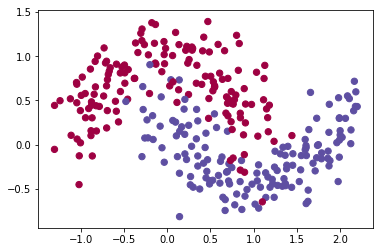

In [12]:
train_X, train_Y = load_dataset()
plt.show()

In [45]:
a = DeepNeuralNetwork("Model with Gradient Descent optimization", [train_X.shape[0], 5, 2, 1])
a.iteration_unit = 100

You created a deep neural network named 'Model with Gradient Descent optimization'
The layer list is [2, 5, 2, 1]


Cost after iteration 0: 0.702414
Accuracy: 50.0%
Cost after iteration 1000: 0.692824
Accuracy: 65.0%
Cost after iteration 2000: 0.649731
Accuracy: 66.0%
Cost after iteration 3000: 0.577014
Accuracy: 68.33333333333333%
Cost after iteration 4000: 0.585449
Accuracy: 70.33333333333334%
Cost after iteration 5000: 0.549501
Accuracy: 71.66666666666667%
Cost after iteration 6000: 0.533511
Accuracy: 73.33333333333333%
Cost after iteration 7000: 0.423509
Accuracy: 75.0%
Cost after iteration 8000: 0.503897
Accuracy: 76.0%
Cost after iteration 9000: 0.503793
Accuracy: 78.66666666666666%
Cost after iteration 10000: 0.435286
Accuracy: 79.66666666666666%
finished!


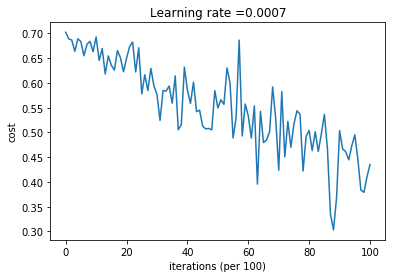

[0.7024140504990622,
 0.6891053028867816,
 0.6866108211627802,
 0.6638917857161126,
 0.6891757162154073,
 0.6836401980284096,
 0.6550447693011406,
 0.6781487729055178,
 0.6839671365553485,
 0.6630943656549688,
 0.6928241041100953,
 0.6455193555736257,
 0.6694871700230733,
 0.6180993016200979,
 0.6546282821959931,
 0.6357378753081967,
 0.6258689706454881,
 0.6654028311917112,
 0.6510230200518802,
 0.6225514034458712,
 0.6497307455344047,
 0.6733689658897128,
 0.6826715591041218,
 0.6221573828219531,
 0.6710633224254634,
 0.5778595128276482,
 0.6165546883960057,
 0.5846117732957989,
 0.6294713603813982,
 0.5938437922671109,
 0.5770144736686824,
 0.5243641386652024,
 0.5848850338834046,
 0.5835564243075672,
 0.5937384467588818,
 0.5591480118585623,
 0.6142589061630017,
 0.5054252803975781,
 0.5156921855701297,
 0.6318151473185736,
 0.5854490923875358,
 0.5585754798005939,
 0.6016002012492015,
 0.5419433309575082,
 0.5449802975724481,
 0.5131265385684466,
 0.5072477475516861,
 0.5080782367

In [46]:
a.Train_Gradient_Descent(train_X, train_Y)

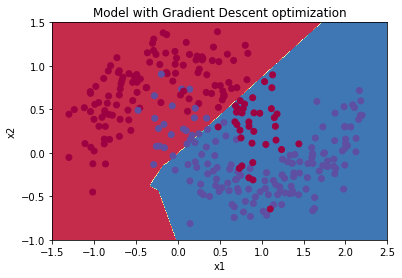

In [47]:
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: a.Predict(x.T), train_X, np.squeeze(train_Y))
plt.show()

In [49]:
b = DeepNeuralNetwork("Model with Momentum optimization", [train_X.shape[0], 5, 2, 1])
b.iteration_unit = 100

You created a deep neural network named 'Model with Momentum optimization'
The layer list is [2, 5, 2, 1]


Cost after iteration 0: 0.702414
Accuracy: 50.0%
Cost after iteration 1000: 0.692880
Accuracy: 65.0%
Cost after iteration 2000: 0.649846
Accuracy: 66.0%
Cost after iteration 3000: 0.577131
Accuracy: 68.33333333333333%
Cost after iteration 4000: 0.585530
Accuracy: 70.33333333333334%
Cost after iteration 5000: 0.549577
Accuracy: 71.66666666666667%
Cost after iteration 6000: 0.533600
Accuracy: 73.33333333333333%
Cost after iteration 7000: 0.423654
Accuracy: 75.0%
Cost after iteration 8000: 0.504134
Accuracy: 76.0%
Cost after iteration 9000: 0.503930
Accuracy: 78.66666666666666%
Cost after iteration 10000: 0.435499
Accuracy: 79.66666666666666%
finished!


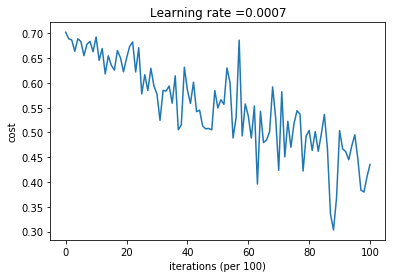

[0.7024140504990622,
 0.6891545271450209,
 0.6866805758938971,
 0.6639669573640734,
 0.6892336532865658,
 0.6836906762027638,
 0.6551505622803604,
 0.6782082328454961,
 0.6839937152533013,
 0.6631525505449504,
 0.6928802091294768,
 0.6456002534345816,
 0.6695464414000376,
 0.6182220977392728,
 0.6546658026345075,
 0.6358163112761044,
 0.625953129014181,
 0.6654288310691657,
 0.6510711738934758,
 0.6226665982082414,
 0.6498455917557446,
 0.6734300616007626,
 0.6827538671631246,
 0.6222328119154048,
 0.6711165090226043,
 0.5779748188199555,
 0.6166534626565346,
 0.5847118661862137,
 0.6295784037624302,
 0.5939550534794787,
 0.5771311473500471,
 0.5245050243053794,
 0.5850111745073754,
 0.5836641835490872,
 0.593808329225765,
 0.5592608590718989,
 0.6143485772226295,
 0.505540087592439,
 0.5157551982548729,
 0.6318296845921748,
 0.5855303030956476,
 0.5586029698304504,
 0.6016385532960408,
 0.5420410436782919,
 0.5451099627687416,
 0.5132289114001214,
 0.5073233706925779,
 0.5082471316024

In [50]:
b.Train_Momentum(train_X, train_Y, beta = 0.9)

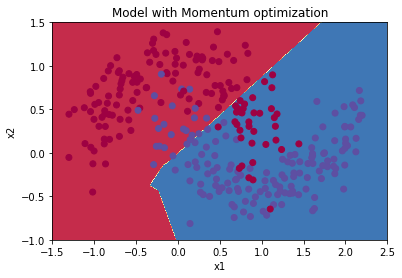

In [51]:
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: b.Predict(x.T), train_X, np.squeeze(train_Y))
plt.show()

In [52]:
c = DeepNeuralNetwork("Model with Adam optimization", [train_X.shape[0], 5, 2, 1])
c.iteration_unit = 100

You created a deep neural network named 'Model with Adam optimization'
The layer list is [2, 5, 2, 1]


Cost after iteration 0: 0.702414
Accuracy: 50.0%
Cost after iteration 1000: 0.120354
Accuracy: 93.0%
Cost after iteration 2000: 0.268981
Accuracy: 93.66666666666667%
Cost after iteration 3000: 0.070291
Accuracy: 93.33333333333333%
Cost after iteration 4000: 0.101921
Accuracy: 94.33333333333334%
Cost after iteration 5000: 0.039783
Accuracy: 94.33333333333334%
Cost after iteration 6000: 0.063986
Accuracy: 94.0%
Cost after iteration 7000: 0.102836
Accuracy: 94.0%
Cost after iteration 8000: 0.091528
Accuracy: 94.0%
Cost after iteration 9000: 0.176457
Accuracy: 94.0%
Cost after iteration 10000: 0.169372
Accuracy: 94.0%
finished!


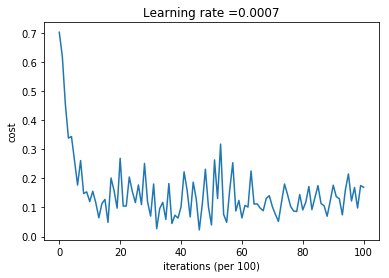

[0.7024140504990622,
 0.6186367610225025,
 0.45402282141391254,
 0.33857492556159674,
 0.34384387762527224,
 0.26133979283280956,
 0.1770369092289894,
 0.2612322253609519,
 0.1478604104939494,
 0.1534895061375904,
 0.12035351704490899,
 0.1556906256469865,
 0.11572259331111268,
 0.06447087614967417,
 0.11300354584007803,
 0.1277080631268453,
 0.04872356122199783,
 0.20124164470278366,
 0.15775527320321533,
 0.09751513673077868,
 0.2689813642721174,
 0.10475860533913631,
 0.10485563873947812,
 0.20468820023533388,
 0.15480622205222397,
 0.11671185061558184,
 0.17736230647967252,
 0.10986152065087294,
 0.2512822176296225,
 0.11954830116328949,
 0.0702913254942719,
 0.18073509804122864,
 0.02708122485447102,
 0.09627341837901189,
 0.11750705728732455,
 0.05892738226205946,
 0.18229411037262913,
 0.044882445858975856,
 0.07344414112104847,
 0.06331475509910975,
 0.10192101512285431,
 0.22227255764974022,
 0.15935130664688277,
 0.06736908493241565,
 0.18704572310279513,
 0.12860533424314874

In [53]:
c.Train_Adam(train_X, train_Y)

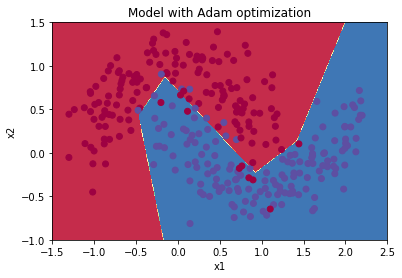

In [54]:
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: c.Predict(x.T), train_X, np.squeeze(train_Y))
plt.show()

In [61]:
d = DeepNeuralNetwork("Model without optimization", [train_X.shape[0], 5, 2, 1])
d.iteration_unit = 100

You created a deep neural network named 'Model without optimization'
The layer list is [2, 5, 2, 1]


Cost after iteration 0: 0.702414
Accuracy: 50.0%
Cost after iteration 1000: 0.140178
Accuracy: 93.66666666666667%
Cost after iteration 2000: 0.123082
Accuracy: 94.33333333333334%
Cost after iteration 3000: 0.119023
Accuracy: 94.66666666666667%
Cost after iteration 4000: 0.118216
Accuracy: 94.66666666666667%
Cost after iteration 5000: 0.117024
Accuracy: 95.0%
Cost after iteration 6000: 0.116281
Accuracy: 95.0%
Cost after iteration 7000: 0.115868
Accuracy: 95.0%
Cost after iteration 8000: 0.115418
Accuracy: 95.0%
Cost after iteration 9000: 0.115229
Accuracy: 95.0%
Cost after iteration 10000: 0.115034
Accuracy: 95.0%
finished!


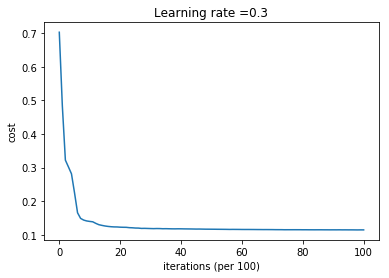

[0.7024140504990622,
 0.48391566483889803,
 0.3223609098058707,
 0.3022423973400143,
 0.28173535828884033,
 0.22549613872726432,
 0.1658054360293742,
 0.1492111761581972,
 0.14421612765403394,
 0.14159707712451816,
 0.14017790448164733,
 0.13905702418118437,
 0.13438453578654005,
 0.13046521267031727,
 0.1284248114933406,
 0.12666517425578885,
 0.12536585771323447,
 0.12446461088619648,
 0.1238843438389692,
 0.12375271295201297,
 0.12308236485067725,
 0.12278620409981668,
 0.1226708460793816,
 0.12165322140286856,
 0.1212727965260028,
 0.12053930121925387,
 0.1203591573939519,
 0.11941564287027831,
 0.11958827380740976,
 0.1193157750982622,
 0.1190232489059523,
 0.11876797664839144,
 0.11906104724002514,
 0.11894248814178156,
 0.11848190112888513,
 0.11863400816542703,
 0.11840506279697702,
 0.11817726280135342,
 0.11809384071093204,
 0.11826665291438929,
 0.11821554616711236,
 0.1180167975049961,
 0.11791213913581383,
 0.11780341966691779,
 0.11764508804654064,
 0.11746225919638581,
 

In [62]:
d.Train(train_X, train_Y, learning_rate = 0.3, iterations = 10000, print_cost = True)

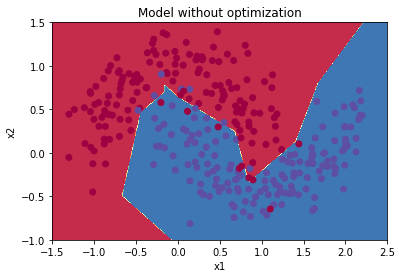

In [64]:
plt.title("Model without optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: d.Predict(x.T), train_X, np.squeeze(train_Y))
plt.show()